In [165]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps

In [167]:
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


/tmp/ipykernel_1587336/638316685.py:10: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc')


In [168]:
# set up descriptor for plotting 
# # set up mesh to apply polypcolor
mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

### get edge and vertex indices for a transect created from an algorithm

In [186]:
# LS_lats= np.array([54, 60, 66, 64, 58])   
# LS_lons= np.array([302, 315, 310, 295, 296])

# LS_lats = np.append(LS_lats, LS_lats[0])
# LS_lons = np.append(LS_lons, LS_lons[0])

# # calculate transects from algorithm, sort vertices & edges to be in consecutive order
test_edges, test_verts = mps.calculate_transects_multiple_pts(LS_lons, LS_lats, mesh)

# from the transect, create a mask to capture the entire region specified by the transects
# this will also output lats and lons corresponding to test_verts
path = './'
filename = 'LS_test'
geojson_file_name = 'Labrador Sea from transect algorithm'
tags = "Labrador_Sea;Davis_Strait"
author = "Kaila Uyeda"

    
test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            mesh, 
                                                                            path,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

# use the dsMasks file to get the ACTUAL working vertices that you will need
# this eliminates duplicate vertices that would occur if the transect moves back on itself
# check that the vertices and edges from the mask are actually at the same plaaces...
# in other words, we have the correct cells for the mask but extra edges and vertices because of how the transect is created.
# we have to do this after we create a mask with the cells. Otherwise, we don't know what side of the boundary
# is considered "inside the mask"

alg_edges, alg_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,dsMasks)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks


In [196]:
# get just the OSNAP edges and vertices

OSNAP_target_start_lat = 54
OSNAP_target_start_lon = 302
OSNAP_target_end_lat = 60
OSNAP_target_end_lon = 315

# get the raw/test edges and vertices.
# we consider these to be "raw" because, by how these points have been chosen,
# cellsOnEdge[nEdge,0] = land cell and cellsOnEdge[nEdge,1] = open ocean not in mask
OSNAP_edges_raw, OSNAP_verts_raw = mps.calculate_transects(OSNAP_target_start_lat, OSNAP_target_start_lon, OSNAP_target_end_lat, OSNAP_target_end_lon, mesh)

# we know that the alg_edges, alg_vertices remove the above discussed edges and vertices by how we define edges on transect 
# take the intersection of OSNAP_*_raw with alg_* to only get the edges and vertices along the transect
OSNAP_edges = np.intersect1d(OSNAP_edges_raw, alg_edges)
OSNAP_vertices = np.intersect1d(OSNAP_verts_raw, alg_vertices)

### get edge and vertex indices for a transect created from a mask

In [170]:
# open mask of desired region (this is to find transects from a pre-existing mask)

path = './'
filename = 'LS_test_transect_from_mask'

check_nc_existence = os.path.isfile(path + filename + '.nc')

# check if .nc mask file exists
if check_nc_existence == True:
    print(f'Opening {filename}.nc file as mask')
    mask = xr.open_dataset(path + filename + '.nc')
else: 
    print('Creating .nc file')
    check_geojson_existence = os.path.isfile(path + filename + '.geojson')

    # convert LS_test.geojson to LS_test.nc mask file
    if check_geojson_existence == True:
        print(f'Using {filename}.geojson to create .nc file')
        fcMask = read_feature_collection(path + filename + '.geojson')
        # pool = create_pool(process_count=8)
        dsMasks = compute_mpas_region_masks(mesh, fcMask, maskTypes =('cell',), pool=pool)
        dsMasks.to_netcdf(path + filename + '.nc', format='NETCDF4', mode='w')
        mask = xr.open_dataset(path + filename + '.nc')
        print(f'{filename}.nc created and opened as masks')
    else:
        print(f'{filename}.geojson does NOT exist!')

mask_edges, mask_vertices = mps.find_and_sort_transect_edges_and_vertices(mesh,mask)

Opening LS_test_transect_from_mask.nc file as mask


### Set up choice of edges and vertices based on method of creation.

In [171]:
method = 'alg' # 'mask'
if method == 'alg':
    edges, vertices = alg_edges, alg_vertices
    mask = dsMasks

if method == 'mask':
    edges, vertices = mask_edges, mask_vertices
    mask = mask

### A note on sign convention from normal velocity taken from [this python script on Github](https://github.com/milenaveneziani/analysis/blob/c7eb78deabb6fe9529d43fecdae6ce700eefff38/common_functions.py#L119) where 
`cellsOnEdge[nEdge,0]` is equivalent to my use of `A` cell, and \
`cellsonEdge[nEdge,1]` is equivalent to my use of `B` cell.

```ruby
# Compute edgeSigns so that transport INTO the region is positive. This is 
    # calculated considering that normalVelocity is positive when pointing from
    # cellsOnEdges[nEdge, 0] to cellsOnEdges[nEdge, 1]. Therefore, if 
    # cellsOnEdges[nEdge, 0] is outside the region and cellsOnEdges[nEdge, 1]
    # is inside the region, the sign remains unchanged (np.sign(regionMask[cellsOnEdges[nEdge, 1]] - 0.5)=1).
    # But, if cellsOnEdges[nEdge, 0] is inside the region and cellsOnEdges[nEdge, 1]
    # is outside the region, then the sign is flipped (np.sign(regionMask[cellsOnEdges[nEdge, 1]] - 0.5)
    # becomes -1. With this reasoning, the following also works (and we have verified that):
    # openBoundarySigns = -np.sign(regionMask[cellsOnEdges[~landEdges, 0]] - 0.5)
```

In [172]:
# Use normal velocity to calculate transport direction (We want positive into the mask and negative out of the mask)
# We make the assumption that normal velocity is positive toward the A cell where mesh.cellsOnEdge = [A,B]

# create a new datavariable for the velocity into the mask to be stored (we will change the normal velocity sign)
# I only subtract 100 because I want to show where land is (nans) and make that distinct from places in the ocean that aren't part of 
# the mask (-100)
def calculate_velo_into_mask(mesh, mask, outside_mask_values):
    mesh['veloIntoMask'] = mesh.normalVelocity * 0 + outside_mask_values
    
    # find edges on land
    xr_all_edgesOnLand_TWO0 = mesh.nEdges.where(np.isin(mesh.cellsOnEdge.isel(TWO=0),0))
    xr_all_edgesOnLand_TWO1 = mesh.nEdges.where(np.isin(mesh.cellsOnEdge.isel(TWO=1),0))
    xr_all_edgesOnLand = np.union1d(xr_all_edgesOnLand_TWO0, xr_all_edgesOnLand_TWO1)
    
    # of those edges on land, get only the ones that are part of the transect
    xr_transect_edgesOnLand = np.intersect1d(edges, xr_all_edgesOnLand)
    
    # get only the open ocean edges
    xr_transect_edgesOnOcean = np.setxor1d(edges, xr_transect_edgesOnLand) 
    
    # make these values a coordinate. This will allow us to later .isel instead of .where without losing the nEdges dimension used to identify the edges
    xr_transect_edgesOnOcean_da = xr.DataArray(
        np.int32(xr_transect_edgesOnOcean),
        coords={"nEdges":np.int32(xr_transect_edgesOnOcean)},
        dims=("nEdges",))
    
    
    # select all the cells inside the mask
    xr_cells_inside, ignore_xr_inside_edges, ignore_xr_inside_vertices = mps.xr_inside_mask_info(mesh,mask)
    
    # of these open ocean edges, determine if the normal velocity is into or out of the mask
    
    # find the cells on open ocean edges
    n_transect_cellsOnOceanEdges =  mesh.cellsOnEdge.isel(nEdges = xr_transect_edgesOnOcean_da)
    xr_transect_cellsOnOceanEdges = mps.n_to_xr_idx(n_transect_cellsOnOceanEdges)

    # determine if the normal velocity points into or out of the mask
    
    for i in range(0,len(xr_transect_edgesOnOcean)):
        cellsOnSelectedEdge = xr_transect_cellsOnOceanEdges.isel(nEdges = i)
        selectedEdge = xr_transect_cellsOnOceanEdges.nEdges[i]
        
        if cellsOnSelectedEdge.isel(TWO=0).isin(xr_cells_inside): # if A is in the mask 
            mesh.veloIntoMask.loc[dict(Time=0, nEdges = selectedEdge)] = mesh.normalVelocity.loc[dict(Time=0,nEdges= selectedEdge)] * -1
            
        if cellsOnSelectedEdge.isel(TWO=1).isin(xr_cells_inside): # if B is in the mask
            mesh.veloIntoMask.loc[dict(Time=0, nEdges = selectedEdge)] = mesh.normalVelocity.loc[dict(Time=0,nEdges = selectedEdge)] * 1

    return mesh,xr_transect_cellsOnOceanEdges

In [173]:
outside_mask_values = np.nan
mesh_plot, xr_transect_cellsOnOceanEdges = calculate_velo_into_mask(mesh,mask,outside_mask_values)

In [174]:
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# c = mosaic.polypcolor(ax,descriptor,
#                   mesh_plot.veloIntoMask.isel(Time=0,nVertLevels=10),cmap='RdBu_r', vmin=-0.5,vmax=0.5,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# # this is making me feel like I should flip the signs of the for loop

In [175]:
# calculate the area of the edge-layerThickness plane that the normal velocity moves through

# --------- INTERPOLATE LAYER THICKNESS ONTO NEDGES ---------
# layerThickness sits on nCells, but veloIntoMask sits on nEdges
# we need to interpolate layerThickness onto nEdges by taking the average of the layerThickness of 2 cells that sit on the transect edge

# select only the layerThicknesses that are on edges in the transect
cellsOnTransectEdge_layerThickness = mesh.layerThickness.isel(Time=0, nCells = xr_transect_cellsOnOceanEdges)

# take the mean of the layer thicknesses along the dimension "TWO" (take the mean of layer thickness between TWO=0 cell and TWO=1 cell)
interp_transectEdgeLayerThickness = cellsOnTransectEdge_layerThickness.mean(dim='TWO')

# --------- FIND THE WIDTH OF EACH TRANSECT EDGE---------
# find the dvEdge for all edges in transect
transectEdgeLength = mesh.dvEdge.isel(nEdges = xr_transect_cellsOnOceanEdges.nEdges)

# --------- CALCULATE THE CROSS-SECTIONAL AREA OF THE TRANSECT BY MULTIPLYING THE LAYERTHICKNESS BY THE EDGELENGTH ---------
transect_area = interp_transectEdgeLayerThickness * transectEdgeLength

# --------- CALCULATE THE TRANSPORT INTO THE MASK --------
# multiply the cross-sectional area by the veloIntoMask
transport = transect_area * mesh.veloIntoMask.isel(Time=0, nEdges = xr_transect_cellsOnOceanEdges.nEdges)

In [261]:
# create a new datavariable for transport, assign the transport to the corresponding edge
mesh['transportIntoMask'] = mesh.veloIntoMask * 0 + np.nan

for i in range(0,len(interp_transectEdgeLayerThickness)):
    selectedEdge = transport.nEdges.isel(nEdges=i)
    
    mesh.transportIntoMask.loc[dict(Time=0, nEdges = selectedEdge)] = transport.loc[dict(nEdges = selectedEdge)]

transportIntoMask_Sv = mesh.transportIntoMask / 10**6

In [177]:
# from the transect, create a mask to capture the entire region specified by the transects
# this will also output lats and lons corresponding to test_verts
filepath = './'
filename = 'LS_test'
geojson_file_name = 'Labrador Sea from transect algorithm'
tags = "Labrador_Sea;Davis_Strait"
author = "Kaila Uyeda"

test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            mesh, 
                                                                            filepath,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

LS_test_transect_from_alg.geojson exists!
Opening LS_test_transect_from_alg.nc as dsMasks


In [304]:
net_transportIntoMask_Sv = transportIntoMask_Sv.isel(Time=0).sum()

In [268]:
column_transport = mesh.transportIntoMask.isel(Time=0).sum(dim='nVertLevels')
OSNAP_column_transport = column_transport.where(np.isin(mesh.nEdges, OSNAP_edges))
OSNAP_column_transport_Sv = OSNAP_column_transport / 10**6

In [294]:
non_OSNAP_column_transport = column_transport.where(~np.isin(mesh.nEdges, OSNAP_edges))
non_OSNAP_column_transport = non_OSNAP_column_transport / 10**6

In [302]:
# PLOT JUST OSNAP
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
# b = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.4,
#                   antialiaseds=False)


# c = mosaic.polypcolor(ax,descriptor,
#                   OSNAP_column_transport_Sv,cmap=cmo.balance,vmin=-10,vmax=10,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# ax.set_title('Net transport into mask through "OSNAP" array is ' + OSNAP_rounded_total_transport)
# # this is making me feel like I should flip the signs of the for loop?? 
# # But then this would mean there's a net increase of water in this region instead of export

In [285]:
# PLOT A SELECTED LEVEL
# fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

# cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
# b = mosaic.polypcolor(ax,descriptor,
#                   cellmask.astype(int),cmap='cool',alpha = 0.4,
#                   antialiaseds=False)


# c = mosaic.polypcolor(ax,descriptor,
#                   transportIntoMask_Sv.isel(Time=0,nVertLevels=20),cmap=cmo.balance,vmin=-0.05,vmax=0.05,
#                   antialiaseds=False)
# ax.set_xlim(290, 318)
# ax.set_ylim(51.5, 68)
# fig.colorbar(c, extend='both')
# # this is making me feel like I should flip the signs of the for loop?? 
# # But then this would mean there's a net increase of water in this region instead of export

In [303]:
OSNAP_rounded_total_transport = str(np.round(OSNAP_column_transport_Sv.sum().values,decimals=3))
str_net_transportIntoMask_Sv = str(np.round(net_transportIntoMask_Sv.values,decimals=3))
str_nonOSNAP_transportIntoMask_Sv = str(np.round(non_OSNAP_column_transport.sum().values,decimals=3))

Text(0.5, 1.0, 'Net transport into mask is 6.038Sv \n OSNAP: 0.385 & non-OSNAP: 5.653')

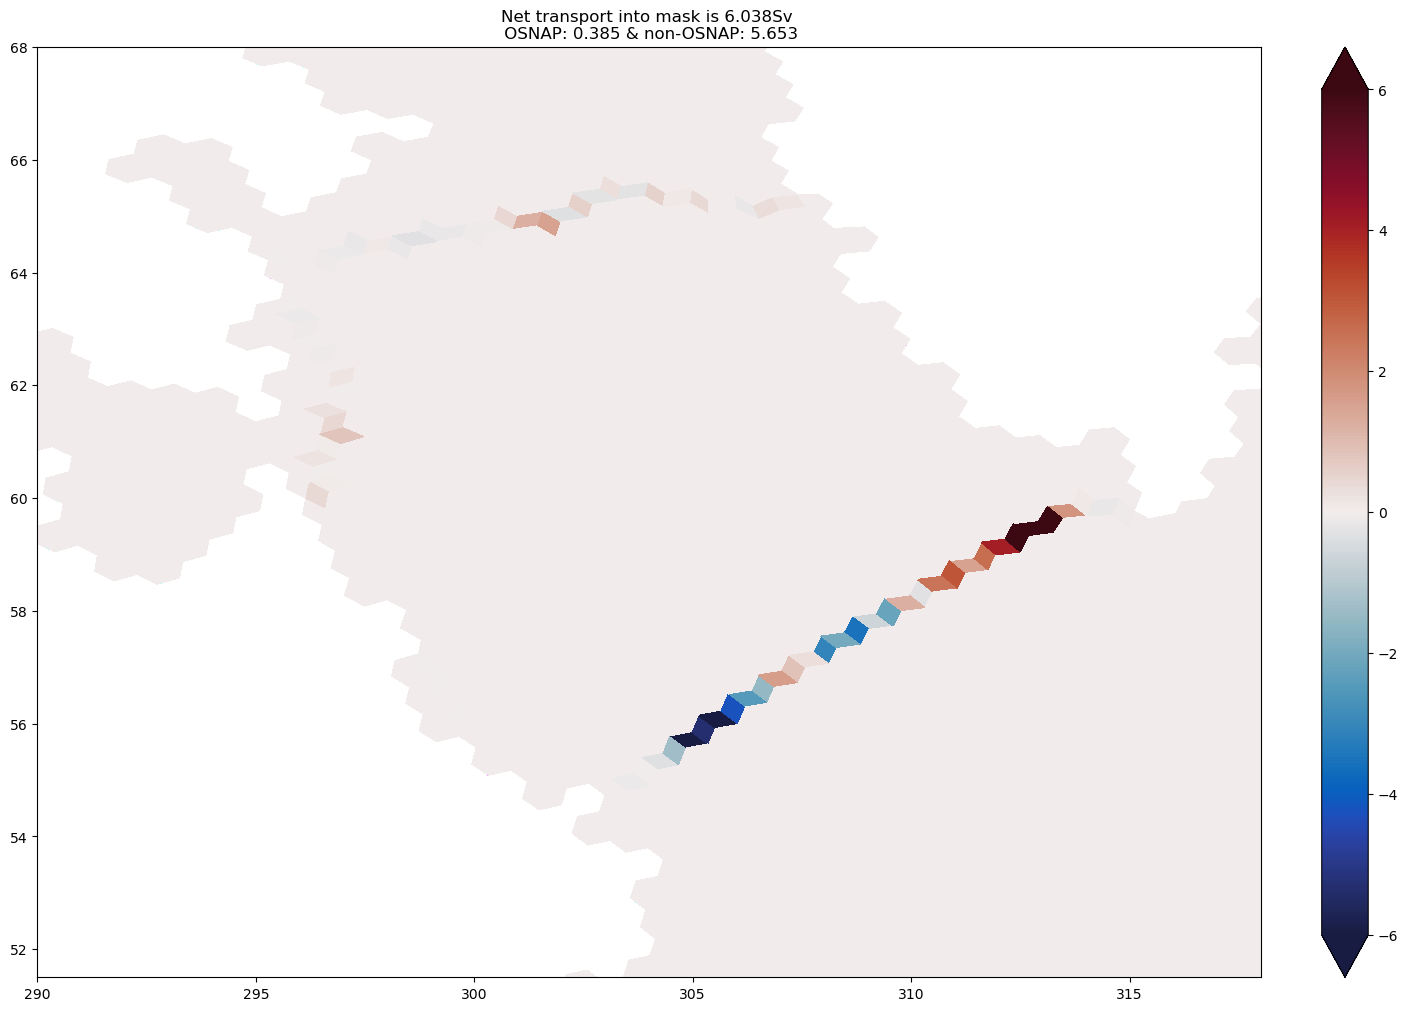

In [300]:

fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(14,10))

cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)
b = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.4,
                  antialiaseds=False)

c = mosaic.polypcolor(ax,descriptor,
                  transportIntoMask_Sv.isel(Time=0).sum(dim='nVertLevels'),cmap=cmo.balance,vmin=-6,vmax=6,
                  antialiaseds=False)


ax.set_xlim(290, 318)
ax.set_ylim(51.5, 68)
fig.colorbar(c, extend='both')
ax.set_title('Net transport into mask is ' + str_net_transportIntoMask_Sv + 'Sv \n OSNAP: ' + OSNAP_rounded_total_transport + ' & non-OSNAP: ' + str_nonOSNAP_transportIntoMask_Sv)
# this is making me feel like I should flip the signs of the for loop?? 
# But then this would mean there's a net increase of water in this region instead of export